In [1]:
# Improt the necessary libraries
import itertools
import xarray as xr
import rasterio
import pandas as pd
import geopandas as gpd
import rioxarray
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
# Filepaths

WTE_FOLDER = "/mnt/drive/AI4EBV/INPUTS/WTE/"
WTE_GLOBAL = "WTE1778.tif"

# Wte table

WTE_TABLE = WTE_FOLDER + "Tables/Realm_WE_attribute_Table_DraftSort.csv"

# South Tyrol shapefile

ST_SHP = "/mnt/drive/AI4EBV/BOUNDARIES/ST.shp"

# Output desired UTM Projection
# It is estimated automatically based on the provided shapefile. Needs to be tested in details. New PROJ version required >7
OUTPUT_CRS = "EPSG:32632"

Read the input WTE layer

In [3]:
wte_global = xr.open_rasterio(WTE_FOLDER + WTE_GLOBAL)
wte_global

<xarray.DataArray (band: 1, y: 3535, x: 6358)>
[22475530 values with dtype=uint32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 50.1 50.1 50.1 50.1 50.1 ... 42.17 42.17 42.17 42.17
  * x        (x) float64 3.643 3.645 3.647 3.649 ... 17.91 17.91 17.92 17.92
Attributes:
    transform:      (0.0022457989999999997, 0.0, 3.64154024832649, 0.0, -0.00...
    crs:            +init=epsg:4326
    res:            (0.0022457989999999997, 0.0022457989999999997)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Generic

Read the input shapefile

In [4]:
df = gpd.read_file(ST_SHP)
df

,COD_REG,COD_PRO,NOME_PRO,SHAPE_Leng,SHAPE_Area,geometry
0,4,21,BOLZANO/BOZEN,664283.497457,7.397682e+09,"POLYGON ((743472.190 5219940.300, 743499.120 5..."


In [5]:
df4326 = df.to_crs(4326)

In [6]:
df_buffer = df4326.copy()

In [7]:
delta = 0.1
minX = df_buffer.geometry.bounds['minx'] - delta
minY = df_buffer.geometry.bounds['miny'] - delta
maxX = df_buffer.geometry.bounds['maxx'] + delta
maxY = df_buffer.geometry.bounds['maxy'] + delta

In [8]:
df_buffer.geometry.bounds

,minx,miny,maxx,maxy
0,10.381765,46.21978,12.477594,47.091779


In [9]:
wte_table = pd.read_csv(WTE_TABLE, sep=';')
wte_table

,RealmWE_ID,WE_ID,Realm_ID,RealmClass,LF_Class,MoistClass,TempClass,LC_Class,Realm_Name,LF_Name,LC_Name,Temp_Name,Moist_Name,Temp_Moist,WEcosystm,RWEcosystm,LandC_Type,Code
0,1005,5,1000,1,1,3,6,6,Afrotropic,Mountains,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Mount...,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6316
1,1010,10,1000,1,3,3,6,6,Afrotropic,Tablelands,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Table...,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6336
2,1016,16,1000,1,2,3,6,6,Afrotropic,Hills,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Hills,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6326
3,1018,18,1000,1,1,3,6,4,Afrotropic,Mountains,Grassland,Polar,Moist,Polar Moist,Polar Moist Grassland on Mountains,Afrotropic Polar Moist Grassland on Mountains,Natural,6314
4,1024,24,1000,1,3,3,6,2,Afrotropic,Tablelands,Shrubland,Polar,Moist,Polar Moist,Polar Moist Shrubland on Tablelands,Afrotropic Polar Moist Shrubland on Tablelands,Natural,6332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,8399,399,8000,8,1,3,3,8,Palearctic,Mountains,Snow and Ice,Warm Temperate,Moist,Warm Temperate Moist,Warm Temperate Moist Snow and Ice on Mountains,Palearctic Warm Temperate Moist Snow and Ice o...,Natural,3318
1777,8400,400,8000,8,3,1,4,3,Palearctic,Tablelands,Forest,Sub Tropical,Desert,Sub Tropical Desert,Sub Tropical Desert Forest on Tablelands,Palearctic Sub Tropical Desert Forest on Table...,Natural,4133
1778,8406,406,8000,8,2,1,5,3,Palearctic,Hills,Forest,Tropical,Desert,Tropical Desert,Tropical Desert Forest on Hills,Palearctic Tropical Desert Forest on Hills,Natural,5123
1779,8412,412,8000,8,3,1,5,2,Palearctic,Tablelands,Shrubland,Tropical,Desert,Tropical Desert,Tropical Desert Shrubland on Tablelands,Palearctic Tropical Desert Shrubland on Tablel...,Natural,5132


# Temperature regime

In [10]:
WTE_TEMPERATURE_RULESET = "./temperature_ruleset.csv"
temperature_ruleset = pd.read_csv(WTE_TEMPERATURE_RULESET, sep=';')
temperature_ruleset

,WTE_temperature_domains,temperature(°C),WTE_temperature_domain_code
0,Tropical,>24,5
1,Subtropical,18:24,4
2,Warm Temperate,10:18,3
3,Cool Temperate,0:10,2
4,Boreal,<0,1
5,Polar,<0 and all months average < 10,0


## WTE Temperature Layer

We set the Polar class to 0 instead of 6 for a better comparison later on. We also drop the pixels == 7 (water), since they are not classified in WTE.

In [11]:
# wte_clipped = wte_global.rio.clip(df4326.geometry, drop=True).astype(float)
wte_clipped = wte_global.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY).astype(float)
wte_clipped = wte_clipped.where(wte_clipped!=0)
na_mask = np.bitwise_not(xr.ufuncs.isnan(wte_clipped))
del(wte_global)
max_value = wte_clipped.max().values
while(max_value>6):
    tempValue = wte_table.loc[wte_table['RealmWE_ID']==max_value]['TempClass']
    if len(tempValue) != 0:
        wte_clipped = wte_clipped.where(wte_clipped!=max_value).fillna(int(tempValue))
    else:
        break
    max_value = wte_clipped.max().values
wte_clipped = wte_clipped.where(wte_clipped!=7)
wte_clipped = wte_clipped.where(na_mask)

Define colors and labels for plotting:

In [12]:
import matplotlib.patches as mpatches
temperature_cmap = {'Polar':"#CCCCCC",'Boreal':"#0007A8",'Cool Temperate':"#00734C",'Warm Temperate':"#70A800",'Subtropical':"#FFFFBE",'Tropical':"#FFAA00"}
legend = []
for i,x in enumerate(temperature_ruleset['WTE_temperature_domain_code']):
    label = temperature_ruleset.loc[temperature_ruleset['WTE_temperature_domain_code']==x]['WTE_temperature_domains'].values[0]
    color = temperature_cmap[label]
    legend.append(mpatches.Patch(color=color,label=label))

colors_diff = ["#00375D","#0000CC","#00CCCC","#E0E0E0","#FFAA00","#CC0000","#660000"]
labels_diff = ["-3 zones","-2 zones","-1 zone","same zone","+1 zone","+2 zones","+3 zones"]
legend_diff = []
for i,x in enumerate(labels_diff):
    legend_diff.append(mpatches.Patch(color=colors_diff[i],label=x))

Create cmap for temperature layer

In [13]:
cmap_temp = ListedColormap(["#CCCCCC","#0007A8","#00734C","#70A800","#FFFFBE","#FFAA00"])

Create cmap for difference layer

In [14]:
diff_cmap = ListedColormap(["#00375D","#0000CC","#00CCCC","#E0E0E0","#FFAA00","#CC0000","#660000"])

Reproject to the desired UTM projection:

In [15]:
# wte_temp_UTM = wte_clipped.rio.reproject(OUTPUT_CRS,resolution=250, resampling=0)
wte_temp_UTM = wte_clipped.rio.reproject(wte_clipped.rio.estimate_utm_crs(),resolution=250, resampling=6) # New Proj required
wte_temp_UTM = wte_temp_UTM.rio.clip(df.geometry, drop=True)
wte_temp_UTM = wte_temp_UTM.where(np.bitwise_or(wte_temp_UTM!=6,wte_temp_UTM!=0)).fillna(0)
wte_temp_UTM = wte_temp_UTM.where(wte_temp_UTM!=0).fillna(np.nan)
na_mask = np.bitwise_not(xr.ufuncs.isnan(wte_temp_UTM))
wte_temp_UTM = wte_temp_UTM.where(wte_temp_UTM!=6).fillna(0)
wte_temp_UTM = wte_temp_UTM.where(na_mask)

[]

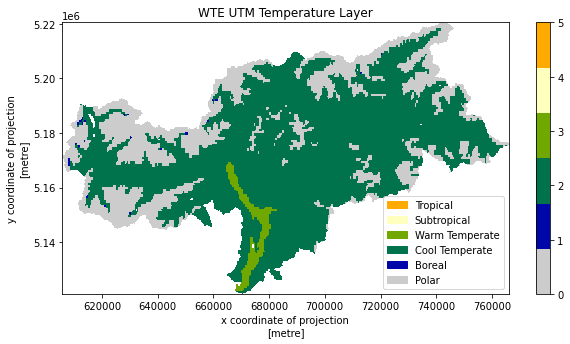

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
fig = wte_temp_UTM[0].plot.imshow(ax=ax,cmap=cmap_temp,vmax=5, vmin=0)
ax.set_title("WTE UTM Temperature Layer")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [17]:
wte_temp_UTM.attrs["_FillValue"] = np.nan

In [18]:
# wte_temp_UTM[0].to_netcdf("wte_temp_UTM_ST.nc")

## Worldclim 2.1

In [19]:
WORLDCLIM_ROOT = "/mnt/drive/AI4EBV/INPUTS/CLIMATE/WORLDCLIM/v2.1/"
#Mean annual temperature: /CLIMATE/WORLDCLIM/v2.1/wc2.1_30s_bio_1.tif 
WORLDCLIM_2_1_ANNUAL_MEAN = WORLDCLIM_ROOT + "wc2.1_30s_bio_1.tif"
#Mean monthly temperatures: /CLIMATE/WORLDCLIM/v2.1/wc2.1_30s_tavg_xx.tif
WORLDCLIM_2_1_MONTHLY_MEAN = [WORLDCLIM_ROOT +"wc2.1_30s_tavg_"+ str(x).zfill(2) + ".tif" for x in range(1,13)]

Annual mean

In [20]:
worldclim_annual = xr.open_rasterio(WORLDCLIM_2_1_ANNUAL_MEAN)
print(worldclim_annual)

<xarray.DataArray (band: 1, y: 21600, x: 43200)>
[933120000 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 90.0 89.99 89.98 89.97 ... -89.97 -89.98 -89.99 -90.0
  * x        (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0 180.0
Attributes:
    transform:      (0.008333333333333333, 0.0, -180.0, 0.0, -0.0083333333333...
    crs:            +init=epsg:4326
    res:            (0.008333333333333333, 0.008333333333333333)
    is_tiled:       0
    nodatavals:     (-3.4e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


Clip the data to our region of interest

In [21]:
worldclim_annual_clipped = worldclim_annual.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY).astype(float)
del(worldclim_annual)
worldclim_annual_clipped = worldclim_annual_clipped.where(worldclim_annual_clipped!=worldclim_annual_clipped.attrs["_FillValue"])
worldclim_annual_clipped.attrs["_FillValue"] = np.nan
worldclim_annual_clipped = worldclim_annual_clipped.compute()

/home/euracuser/miniconda3/envs/pysegcnn/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (-3.4e+38) has been automatically changed to (-3.3999999521443642e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


[]

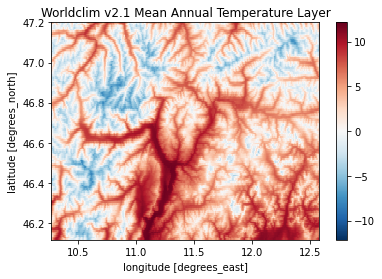

In [22]:
fig, ax = plt.subplots()
worldclim_annual_clipped[0].plot.imshow(ax=ax)
ax.set_title("Worldclim v2.1 Mean Annual Temperature Layer")
plt.plot()

Monthly mean

In [23]:
for i,m in enumerate(WORLDCLIM_2_1_MONTHLY_MEAN):
    if i==0:
        monthly_avg = xr.open_rasterio(m,chunks=1000)
        monthly_avg["month"] = i
        worldclim_months = monthly_avg
    else:
        monthly_avg = xr.open_rasterio(m,chunks=1000)
        monthly_avg["month"] = i
        worldclim_months = xr.concat([worldclim_months,monthly_avg],dim="month")
worldclim_months_min = worldclim_months.min(dim="month")
print(worldclim_months_min)

<xarray.DataArray (band: 1, y: 21600, x: 43200)>
dask.array<nanmin-aggregate, shape=(1, 21600, 43200), dtype=float32, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 90.0 89.99 89.98 89.97 ... -89.97 -89.98 -89.99 -90.0
  * x        (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0 180.0


Clip the data to our region of interest

In [24]:
worldclim_months_min = worldclim_months_min.rio.write_crs(4326)
worldclim_months_min_clipped = worldclim_months_min.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY)
del(worldclim_months_min)

[]

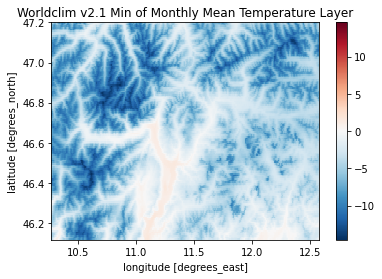

In [25]:
fig, ax = plt.subplots()
worldclim_months_min_clipped[0].plot.imshow(ax=ax)
ax.set_title("Worldclim v2.1 Min of Monthly Mean Temperature Layer")
plt.plot()

Reprojection to 250m in UTM with cubic interpolation

In [26]:
worldclim_annual_clipped_UTM_250m = worldclim_annual_clipped.rio.reproject_match(wte_temp_UTM,2)
worldclim_annual_clipped_UTM_250m = worldclim_annual_clipped_UTM_250m.rio.clip(df.geometry, drop=True)
worldclim_annual_clipped_UTM_250m = worldclim_annual_clipped_UTM_250m.where(worldclim_annual_clipped_UTM_250m!=worldclim_annual_clipped_UTM_250m.attrs["_FillValue"])
worldclim_annual_clipped_UTM_250m.attrs["_FillValue"] = np.nan
worldclim_months_min_clipped_UTM_250m = worldclim_months_min_clipped.rio.reproject_match(wte_temp_UTM,2)
worldclim_months_min_clipped_UTM_250m = worldclim_months_min_clipped_UTM_250m.rio.clip(df.geometry, drop=True)
worldclim_months_min_clipped_UTM_250m = worldclim_months_min_clipped_UTM_250m.where(worldclim_months_min_clipped_UTM_250m!=worldclim_months_min_clipped_UTM_250m.attrs["_FillValue"])
worldclim_months_min_clipped_UTM_250m.attrs["_FillValue"] = np.nan

/home/euracuser/miniconda3/envs/pysegcnn/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


Classification of Worldclim 2.1 according to the WTE scheme

In [27]:
# Create a NaN mask
na_mask = np.bitwise_not(xr.ufuncs.isnan(worldclim_annual_clipped_UTM_250m))
# Create the output layer
worldclim_to_wte_UTM = xr.zeros_like(worldclim_annual_clipped_UTM_250m)

In [28]:
# Tropical: WTE domain code = 5
worldclim_to_wte_UTM = worldclim_to_wte_UTM + (worldclim_annual_clipped_UTM_250m>=24)*5
# Subtropical:  WTE domain code = 4
worldclim_to_wte_UTM = worldclim_to_wte_UTM + (np.bitwise_and(worldclim_annual_clipped_UTM_250m>=18,worldclim_annual_clipped_UTM_250m<24))*4
# Warm Temperate: WTE domain code = 3
worldclim_to_wte_UTM = worldclim_to_wte_UTM + (np.bitwise_and(worldclim_annual_clipped_UTM_250m>=10,worldclim_annual_clipped_UTM_250m<18))*3
# Cool Temperate: WTE domain code = 2
worldclim_to_wte_UTM = worldclim_to_wte_UTM + (np.bitwise_and(worldclim_annual_clipped_UTM_250m>=0,worldclim_annual_clipped_UTM_250m<10))*2
# Boreal: WTE domain code = 1
worldclim_to_wte_UTM = worldclim_to_wte_UTM + (np.bitwise_and(worldclim_annual_clipped_UTM_250m<0,worldclim_months_min_clipped_UTM_250m>=10))*1
# Polar: WTE domain code = 0
worldclim_to_wte_UTM = worldclim_to_wte_UTM + (np.bitwise_and(worldclim_annual_clipped_UTM_250m<0,worldclim_months_min_clipped_UTM_250m<10))*0
# Apply NaNs mask
worldclim_to_wte_UTM = worldclim_to_wte_UTM.where(na_mask)

[]

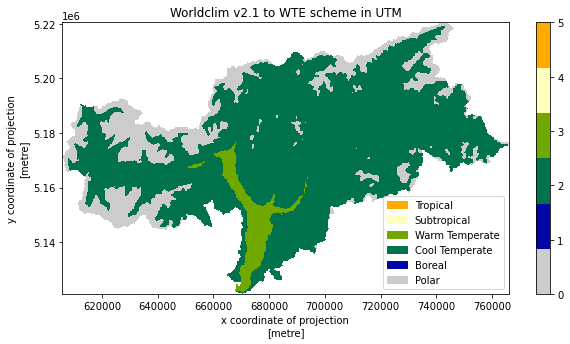

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
fig = worldclim_to_wte_UTM[0].plot.imshow(ax=ax,cmap=cmap_temp,vmax=5, vmin=0)
ax.set_title("Worldclim v2.1 to WTE scheme in UTM")
ax.legend(handles=legend,loc='lower right')
plt.plot()

In [30]:
# worldclim_to_wte_UTM[0].to_netcdf("worldclim_to_wte_temp_UTM_ST.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [31]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_temp_UTM),xr.ufuncs.isnan(worldclim_to_wte_UTM)))
wte_temp_UTM_masked_worldclim = wte_temp_UTM.where(na_mask)
worldclim_to_wte_UTM_masked = worldclim_to_wte_UTM.where(na_mask)

Now that we have both temperature layers with the same class scheme and projection we can compute the difference:

In [32]:
wte_worldclim_2_1_diff = wte_temp_UTM_masked_worldclim - worldclim_to_wte_UTM_masked

[]

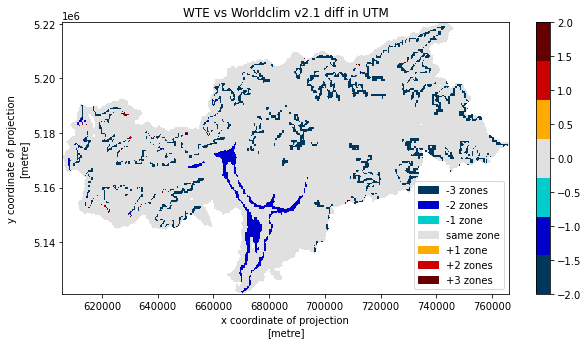

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
fig = wte_worldclim_2_1_diff[0].plot.imshow(ax=ax,cmap=diff_cmap,vmax=2, vmin=-2)
ax.set_title("WTE vs Worldclim v2.1 diff in UTM")
ax.legend(handles=legend_diff,loc='lower right')
plt.plot()

## Chelsa 1.2

In [34]:
CHELSA_ROOT = "/mnt/drive/AI4EBV/INPUTS/CLIMATE/CHELSA/"
#Mean annual temperature: /CLIMATE/CHELSA/CHELSA_bio10_01.tif
CHELSA_ANNUAL_MEAN = CHELSA_ROOT + "CHELSA_bio10_01.tif"
#Mean monthly temperatures: /CLIMATE/CHELSA/CHELSA_temp10_xx_1979-2013_V1.2_land.tif
CHELSA_MONTHLY_MEAN = [CHELSA_ROOT +"CHELSA_temp10_"+ str(x).zfill(2) + "_1979-2013_V1.2_land.tif" for x in range(1,13)]

Annual mean

In [35]:
chelsa_annual = xr.open_rasterio(CHELSA_ANNUAL_MEAN)
print(chelsa_annual)

<xarray.DataArray (band: 1, y: 20880, x: 43200)>
[902016000 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 84.0 83.99 83.98 83.97 ... -89.97 -89.98 -89.99 -90.0
  * x        (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0 180.0
Attributes:
    transform:      (0.0083333333, 0.0, -180.00013888885002, 0.0, -0.00833333...
    crs:            +init=epsg:4326
    res:            (0.0083333333, 0.0083333333)
    is_tiled:       0
    nodatavals:     (-32768.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


Clip the data to our region of interest

In [36]:
chelsa_annual_clipped = chelsa_annual.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY)
del(chelsa_annual)
chelsa_annual_clipped = chelsa_annual_clipped.where(chelsa_annual_clipped!=chelsa_annual_clipped.attrs["_FillValue"])
chelsa_annual_clipped.attrs["_FillValue"] = np.nan
chelsa_annual_clipped = chelsa_annual_clipped.compute()

The data has to be recaled back to °C, we need to divide it by factor 10

In [37]:
chelsa_annual_clipped = chelsa_annual_clipped/10

[]

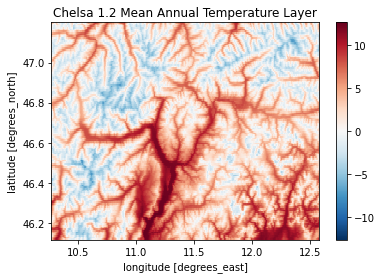

In [38]:
fig, ax = plt.subplots()
chelsa_annual_clipped[0].plot.imshow(ax=ax)
ax.set_title("Chelsa 1.2 Mean Annual Temperature Layer")
plt.plot()

Monthly mean

In [39]:
for i,m in enumerate(CHELSA_MONTHLY_MEAN):
    if i==0:
        monthly_avg = xr.open_rasterio(m,chunks=1000)
        monthly_avg["month"] = i
        chelsa_months = monthly_avg
    else:
        monthly_avg = xr.open_rasterio(m,chunks=1000)
        monthly_avg["month"] = i
        chelsa_months = xr.concat([chelsa_months,monthly_avg],dim="month")
chelsa_months_min = chelsa_months.min(dim="month")
print(chelsa_months_min)

<xarray.DataArray (band: 1, y: 20880, x: 43200)>
dask.array<amin-aggregate, shape=(1, 20880, 43200), dtype=int16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 84.0 83.99 83.98 83.97 ... -89.97 -89.98 -89.99 -90.0
  * x        (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0 180.0


Clip the data to our region of interest

In [40]:
chelsa_months_min = chelsa_months_min.rio.write_crs(4326)
chelsa_months_min_clipped = chelsa_months_min.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY)
chelsa_months_min_clipped = chelsa_months_min_clipped/10 # Rescaling to °C
del(chelsa_months_min)

[]

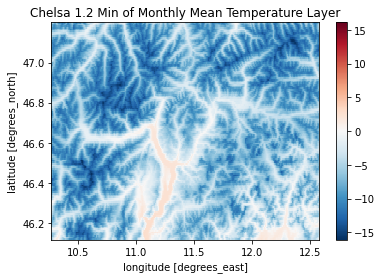

In [41]:
fig, ax = plt.subplots()
chelsa_months_min_clipped[0].plot.imshow(ax=ax)
ax.set_title("Chelsa 1.2 Min of Monthly Mean Temperature Layer")
plt.plot()

Reprojection to 250m in UTM with cubic interpolation

In [42]:
chelsa_annual_clipped_UTM_250m = chelsa_annual_clipped.rio.reproject_match(wte_temp_UTM,2)
chelsa_annual_clipped_UTM_250m = chelsa_annual_clipped_UTM_250m.rio.clip(df.geometry, drop=True)
chelsa_annual_clipped_UTM_250m = chelsa_annual_clipped_UTM_250m.where(chelsa_annual_clipped_UTM_250m!=chelsa_annual_clipped_UTM_250m.attrs["_FillValue"])
chelsa_annual_clipped_UTM_250m.attrs["_FillValue"] = np.nan
chelsa_months_min_clipped_UTM_250m = chelsa_months_min_clipped.rio.reproject_match(wte_temp_UTM,2)
chelsa_months_min_clipped_UTM_250m = chelsa_months_min_clipped_UTM_250m.rio.clip(df.geometry, drop=True)
chelsa_months_min_clipped_UTM_250m = chelsa_months_min_clipped_UTM_250m.where(chelsa_months_min_clipped_UTM_250m!=chelsa_months_min_clipped_UTM_250m.attrs["_FillValue"])
chelsa_months_min_clipped_UTM_250m.attrs["_FillValue"] = np.nan

Classification of Chelsa 1.2 according to the WTE scheme

In [43]:
# Create a NaN mask
na_mask = np.bitwise_not(xr.ufuncs.isnan(chelsa_annual_clipped_UTM_250m))
# Create the output layer
chelsa_to_wte_UTM = xr.zeros_like(chelsa_annual_clipped_UTM_250m)

In [44]:
# Tropical: WTE domain code = 5
chelsa_to_wte_UTM = chelsa_to_wte_UTM + (chelsa_annual_clipped_UTM_250m>=24)*5
# Subtropical:  WTE domain code = 4
chelsa_to_wte_UTM = chelsa_to_wte_UTM + (np.bitwise_and(chelsa_annual_clipped_UTM_250m>=18,chelsa_annual_clipped_UTM_250m<24))*4
# Warm Temperate: WTE domain code = 3
chelsa_to_wte_UTM = chelsa_to_wte_UTM + (np.bitwise_and(chelsa_annual_clipped_UTM_250m>=10,chelsa_annual_clipped_UTM_250m<18))*3
# Cool Temperate: WTE domain code = 2
chelsa_to_wte_UTM = chelsa_to_wte_UTM + (np.bitwise_and(chelsa_annual_clipped_UTM_250m>=0,chelsa_annual_clipped_UTM_250m<10))*2
# Boreal: WTE domain code = 1
chelsa_to_wte_UTM = chelsa_to_wte_UTM + (np.bitwise_and(chelsa_annual_clipped_UTM_250m<0,chelsa_annual_clipped_UTM_250m>=10))*1
# Polar: WTE domain code = 0
chelsa_to_wte_UTM = chelsa_to_wte_UTM + (np.bitwise_and(chelsa_annual_clipped_UTM_250m<0,chelsa_annual_clipped_UTM_250m<10))*0
# Apply NaNs mask
chelsa_to_wte_UTM = chelsa_to_wte_UTM.where(na_mask)

[]

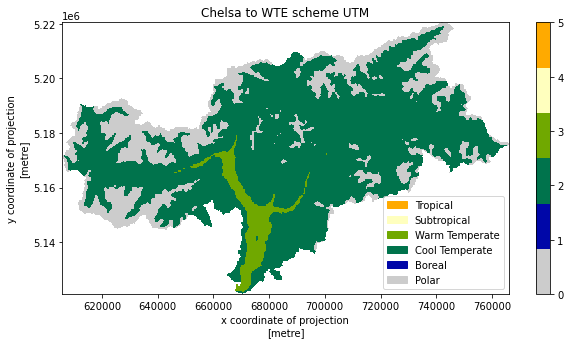

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
fig = chelsa_to_wte_UTM[0].plot.imshow(ax=ax,cmap=cmap_temp,vmax=5, vmin=0)
ax.set_title("Chelsa to WTE scheme UTM")
ax.legend(handles=legend,loc='lower right')
plt.plot()

In [46]:
# chelsa_to_wte_UTM[0].to_netcdf("chelsa_to_wte_temp_UTM_ST.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [47]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_temp_UTM),xr.ufuncs.isnan(chelsa_to_wte_UTM)))
wte_temp_UTM_masked_chelsa = wte_temp_UTM.where(na_mask)
chelsa_to_wte_UTM_masked = chelsa_to_wte_UTM.where(na_mask)

Now that we have both temperature layers with the same class scheme and projection we can compute the difference:

In [48]:
wte_chelsa_1_2_diff = wte_temp_UTM_masked_chelsa - chelsa_to_wte_UTM_masked

[]

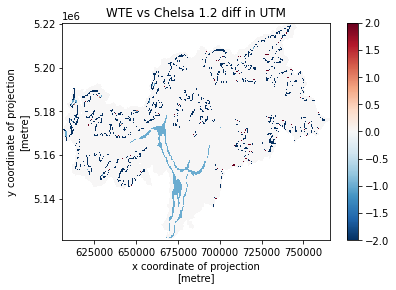

In [49]:
fig, ax = plt.subplots()
wte_chelsa_1_2_diff[0].plot.imshow(ax=ax)
ax.set_title("WTE vs Chelsa 1.2 diff in UTM")
plt.plot()

## EURAC

In [50]:
EURAC_ROOT = "/mnt/drive/AI4EBV/INPUTS/CLIMATE/EURAC/"
#Mean annual temperature: /CLIMATE/EURAC/TEMP_1980_2010.tif 
EURAC_ANNUAL_MEAN = EURAC_ROOT + "TEMP_1980_2010.tif"
#Mean monthly temperatures: /CLIMATE/EURAC/Climatologies_1981_2010_MonthlyMeanTemp.nc 
EURAC_MONTHLY_MEAN = EURAC_ROOT + "/Climatologies_1981_2010_MonthlyMeanTemp.nc"

Annual mean

In [51]:
eurac_annual = xr.open_rasterio(EURAC_ANNUAL_MEAN,chunks=1000)[0]
print(eurac_annual)

<xarray.DataArray (y: 643, x: 641)>
dask.array<getitem, shape=(643, 641), dtype=float32, chunksize=(643, 641), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * y        (y) float64 5.22e+06 5.22e+06 5.22e+06 ... 5.06e+06 5.06e+06
  * x        (x) float64 6.058e+05 6.061e+05 6.063e+05 ... 7.656e+05 7.658e+05
Attributes:
    transform:      (250.0, 0.0, 605720.00012, 0.0, -250.0, 5220237.4801)
    crs:            +init=epsg:32632
    res:            (250.0, 250.0)
    is_tiled:       0
    nodatavals:     (-3.4e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


Clip the data to our region of interest

In [52]:
eurac_annual_clipped = eurac_annual.rio.clip(df.geometry, drop=True)
eurac_annual_clipped = eurac_annual_clipped.where(eurac_annual_clipped!=eurac_annual_clipped.attrs["_FillValue"])
eurac_annual_clipped.attrs["_FillValue"] = np.nan

/home/euracuser/miniconda3/envs/pysegcnn/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (-3.4e+38) has been automatically changed to (-3.3999999521443642e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


[]

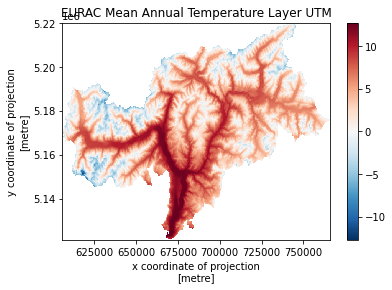

In [53]:
fig, ax = plt.subplots()
eurac_annual_clipped.plot.imshow(ax=ax)
ax.set_title("EURAC Mean Annual Temperature Layer UTM")
plt.plot()

Monthly mean

In [54]:
eurac_months = xr.open_dataset(EURAC_MONTHLY_MEAN).drop('transverse_mercator')
eurac_months_min = eurac_months.min(dim="month").to_array()[0]

Clip the data to our region of interest

In [55]:
eurac_months_min = eurac_months_min.rio.write_crs(OUTPUT_CRS)
eurac_months_min_clipped = eurac_months_min.rio.clip(df.geometry, drop=True)

[]

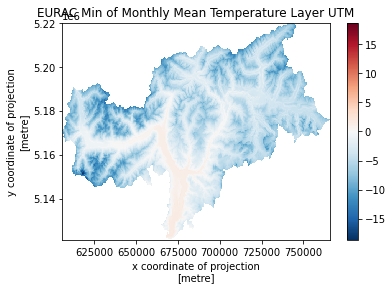

In [56]:
fig, ax = plt.subplots()
eurac_months_min_clipped.plot.imshow(ax=ax)
ax.set_title("EURAC Min of Monthly Mean Temperature Layer UTM")
plt.plot()

Reprojection to 250m in UTM with cubic interpolation

In [57]:
eurac_annual_clipped_UTM_250m = eurac_annual_clipped.rio.reproject_match(wte_temp_UTM,2)
eurac_months_min_clipped_UTM_250m = eurac_months_min_clipped.rio.reproject_match(wte_temp_UTM,2)

Classification of EURAC according to the WTE scheme

In [58]:
# Create a NaN mask
na_mask = np.bitwise_not(xr.ufuncs.isnan(eurac_annual_clipped_UTM_250m))
# Create the output layer
eurac_to_wte_UTM = xr.zeros_like(eurac_annual_clipped_UTM_250m)

In [59]:
# Tropical: WTE domain code = 5
eurac_to_wte_UTM = eurac_to_wte_UTM + (eurac_annual_clipped_UTM_250m>=24)*5
# Subtropical:  WTE domain code = 4
eurac_to_wte_UTM = eurac_to_wte_UTM + (np.bitwise_and(eurac_annual_clipped_UTM_250m>=18,eurac_annual_clipped_UTM_250m<24))*4
# Warm Temperate: WTE domain code = 3
eurac_to_wte_UTM = eurac_to_wte_UTM + (np.bitwise_and(eurac_annual_clipped_UTM_250m>=10,eurac_annual_clipped_UTM_250m<18))*3
# Cool Temperate: WTE domain code = 2
eurac_to_wte_UTM = eurac_to_wte_UTM + (np.bitwise_and(eurac_annual_clipped_UTM_250m>=0,eurac_annual_clipped_UTM_250m<10))*2
# Boreal: WTE domain code = 1
eurac_to_wte_UTM = eurac_to_wte_UTM + (np.bitwise_and(eurac_annual_clipped_UTM_250m<0,eurac_months_min_clipped_UTM_250m>=10))*1
# Polar: WTE domain code = 0
eurac_to_wte_UTM = eurac_to_wte_UTM + (np.bitwise_and(eurac_annual_clipped_UTM_250m<0,eurac_months_min_clipped_UTM_250m<10))*0
# Apply NaNs mask
eurac_to_wte_UTM = eurac_to_wte_UTM.where(na_mask)

[]

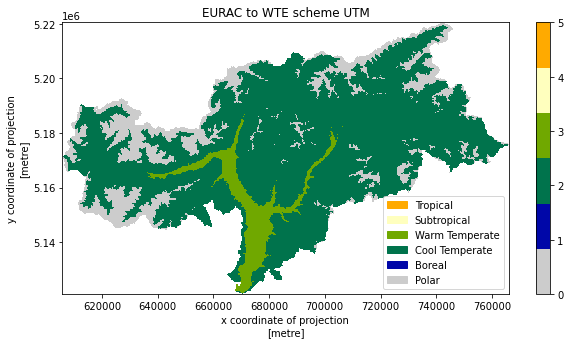

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
fig = eurac_to_wte_UTM.plot.imshow(ax=ax,cmap=cmap_temp,vmax=5, vmin=0)
ax.set_title("EURAC to WTE scheme UTM")
ax.legend(handles=legend,loc='lower right')
plt.plot()

In [61]:
# eurac_to_wte_UTM.to_netcdf("eurac_to_wte_temp_UTM_ST.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [62]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_temp_UTM[0]),xr.ufuncs.isnan(eurac_to_wte_UTM)))
wte_temp_UTM_masked_eurac = wte_temp_UTM[0].where(na_mask)
eurac_to_wte_UTM_masked = eurac_to_wte_UTM.where(na_mask).drop('band')

Now that we have both temperature layers with the same class scheme and projection we can compute the difference:

In [63]:
wte_eurac_diff = wte_temp_UTM_masked_eurac - eurac_to_wte_UTM_masked

[]

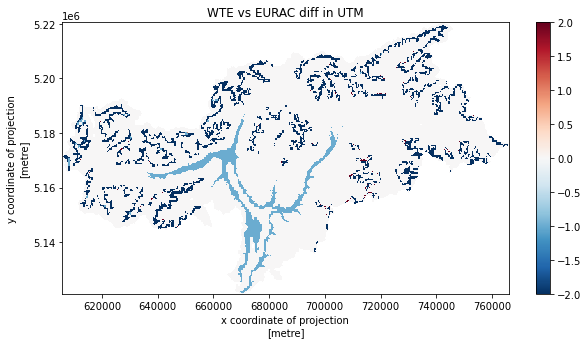

In [64]:
fig, ax = plt.subplots(figsize=(10,5))
fig = wte_eurac_diff.plot.imshow(ax=ax)
ax.set_title("WTE vs EURAC diff in UTM")
plt.plot()

Compute the difference between the regional EURAC layer with the global ones

In [65]:
#EURAC vs WORLDCLIM:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(eurac_to_wte_UTM),xr.ufuncs.isnan(worldclim_to_wte_UTM[0])))
worldclim_to_wte_UTM_masked = worldclim_to_wte_UTM[0].where(na_mask)
eurac_to_wte_UTM_masked     = eurac_to_wte_UTM.where(na_mask).drop('band')
eurac_wc_diff = eurac_to_wte_UTM_masked - worldclim_to_wte_UTM_masked
#EURAC vs CHELSA:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(eurac_to_wte_UTM),xr.ufuncs.isnan(chelsa_to_wte_UTM[0])))
chelsa_to_wte_UTM_masked = chelsa_to_wte_UTM[0].where(na_mask)
eurac_to_wte_UTM_masked  = eurac_to_wte_UTM.where(na_mask).drop('band')
eurac_chelsa_diff = eurac_to_wte_UTM_masked - chelsa_to_wte_UTM_masked

Table resuming the correspondence between the data
1. Compute the number of pixels which are non zero
2. Compute the percentage and the area in km^2 of the difference

In [66]:
#WTE vs WORLDCLIM:
wte_worldclim_diff_km2 = np.count_nonzero(wte_worldclim_2_1_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
wte_worldclim_diff_dis = np.count_nonzero(wte_worldclim_2_1_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_worldclim_2_1_diff))*100 #Percentage of disagreement
#WTE vs CHELSA:
wte_chelsa_diff_km2 = np.count_nonzero(wte_chelsa_1_2_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
wte_chelsa_diff_dis = np.count_nonzero(wte_chelsa_1_2_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_chelsa_1_2_diff))*100 #Percentage of disagreement
#WTE vs EURAC:
wte_eurac_diff_km2 = np.count_nonzero(wte_eurac_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
wte_eurac_diff_dis = np.count_nonzero(wte_eurac_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_eurac_diff))*100 #Percentage of disagreement
#EURAC vs WORLDCLIM:
eurac_wc_diff_km2 = np.count_nonzero(eurac_wc_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
eurac_wc_diff_dis = np.count_nonzero(eurac_wc_diff.fillna(0))/np.count_nonzero(~np.isnan(eurac_wc_diff))*100 #Percentage of disagreement
#EURAC vs CHELSA:
eurac_chelsa_diff_km2 = np.count_nonzero(eurac_chelsa_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
eurac_chelsa_diff_dis = np.count_nonzero(eurac_chelsa_diff.fillna(0))/np.count_nonzero(~np.isnan(eurac_chelsa_diff))*100 #Percentage of disagreement

In [67]:
np.count_nonzero(~np.isnan(eurac_chelsa_diff))

117753

In [68]:
np.count_nonzero(~np.isnan(eurac_wc_diff))

117753

In [69]:
import pandas as pd

data = {'Disagreement [km^2]':  [wte_worldclim_diff_km2, wte_chelsa_diff_km2,wte_eurac_diff_km2,eurac_wc_diff_km2,eurac_chelsa_diff_km2],
        'Disagreement [%]': [wte_worldclim_diff_dis, wte_chelsa_diff_dis,wte_eurac_diff_dis,eurac_wc_diff_dis,eurac_chelsa_diff_dis],
        }

df = pd.DataFrame(data, columns = ['Disagreement [km^2]','Disagreement [%]'],
                        index=['WTE vs Worldclim v1.2','WTE vs Chelsa 2.1','WTE vs EURAC','EURAC vs Worldclim v1.2','EURAC vs Chelsa 2.1'])

df

,Disagreement [km^2],Disagreement [%]
WTE vs Worldclim v1.2,808.6875,10.943830
WTE vs Chelsa 2.1,617.3750,8.354831
WTE vs EURAC,1080.9375,14.704632
EURAC vs Worldclim v1.2,477.1875,6.483911
EURAC vs Chelsa 2.1,529.8750,7.199817


## Comparison plots

In [70]:
def plot_confusion_matrix(ax, cm, labels, normalize=True, cmap='Blues',true="WTE",predicted="predicted"):
    """Plot the confusion matrix ``cm``.
    Parameters
    ----------
    cm : :py:class:`numpy.ndarray`
        The confusion matrix.
    labels : `list` [`str`]
        Names of the classes.
    normalize : `bool`, optional
        Whether to normalize the confusion matrix. The default is `True`.
    figsize : `tuple` [`int`], optional
        The figure size in centimeters. The default is `(10, 10)`.
    cmap : `str`, optional
        A matplotlib colormap. The default is `'Blues'`.
    Returns
    -------
    fig : :py:class:`matplotlib.figure.Figure`
        An instance of :py:class:`matplotlib.figure.Figure`.
    ax : :py:class:`matplotlib.axes._subplots.AxesSubplot`
        An instance of :py:class:`matplotlib.axes._subplots.AxesSubplot`.
    """
    # number of classes
    nclasses = len(labels)

    # string format to plot values of confusion matrix
    fmt = '.0f'

    # minimum and maximum values of the colorbar
    vmin, vmax = 0, cm.max()

    # check whether to normalize the confusion matrix
    if normalize:
        # normalize
        norm = cm.sum(axis=1, keepdims=True)

        # check for division by zero
        norm[norm == 0] = 1
        cm = cm / norm

        # change string format to floating point
        fmt = '.2f'
        vmin, vmax = 0, 1

    # get colormap
    cmap = colormap.get_cmap(cmap, 256)

    # plot confusion matrix
    im = ax.imshow(cm, cmap=cmap, vmin=vmin, vmax=vmax)

    # threshold determining the color of the values
    thresh = (cm.max() + cm.min()) / 2

    # brightest/darkest color of current colormap
    cmap_min, cmap_max = cmap(0), cmap(256)

    # plot values of confusion matrix
    for i, j in itertools.product(range(nclasses), range(nclasses)):
        ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color=cmap_max if cm[i, j] < thresh else cmap_min)

    # axes properties and labels
    ax.set(xticks=np.arange(nclasses),yticks=np.arange(nclasses),xticklabels=labels,yticklabels=labels,ylabel=true,xlabel=predicted)

    # rotate x-tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)

    return


[]

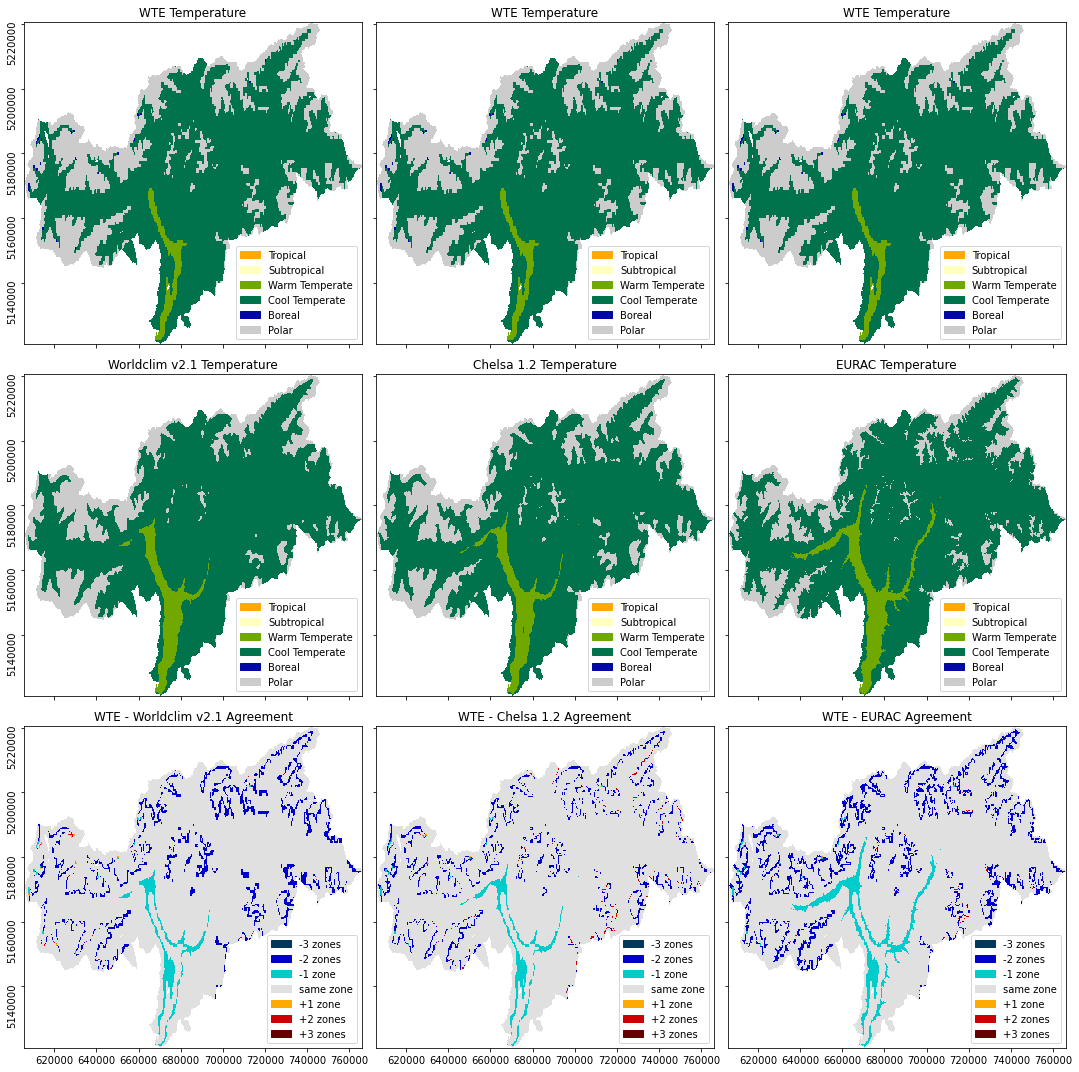

In [71]:
temperature_labels = ['Polar','Boreal','Cool Temperate','Warm Temperate','Subtropical','Tropical']

axis_xmin = wte_temp_UTM_masked_worldclim.x.min().values
axis_ymin = wte_temp_UTM_masked_worldclim.y.min().values
axis_xmax = wte_temp_UTM_masked_worldclim.x.max().values
axis_ymax = wte_temp_UTM_masked_worldclim.y.max().values

fig, ax = plt.subplots(3,3,figsize=(15,15))
fig = wte_temp_UTM_masked_worldclim[0].plot.imshow(ax=ax[0,0],cmap=cmap_temp,vmax=5, vmin=0,add_colorbar=False,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[0,0].set_title("WTE Temperature")
ax[0,0].legend(handles=legend,loc='lower right')
fig = wte_temp_UTM_masked_chelsa[0].plot.imshow(ax=ax[0,1],cmap=cmap_temp,vmax=5, vmin=0,add_colorbar=False,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[0,1].set_title("WTE Temperature")
ax[0,1].legend(handles=legend,loc='lower right')
fig = wte_temp_UTM_masked_eurac.plot.imshow(ax=ax[0,2],cmap=cmap_temp,vmax=5, vmin=0,add_colorbar=False,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[0,2].set_title("WTE Temperature")
ax[0,2].legend(handles=legend,loc='lower right')

fig = worldclim_to_wte_UTM_masked.plot.imshow(ax=ax[1,0],cmap=cmap_temp,vmax=5, vmin=0,add_colorbar=False,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[1,0].set_title("Worldclim v2.1 Temperature")
ax[1,0].legend(handles=legend,loc='lower right')
fig = chelsa_to_wte_UTM_masked.plot.imshow(ax=ax[1,1],cmap=cmap_temp,vmax=5, vmin=0,add_colorbar=False,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[1,1].set_title("Chelsa 1.2 Temperature")
ax[1,1].legend(handles=legend,loc='lower right')
fig = eurac_to_wte_UTM_masked.plot.imshow(ax=ax[1,2],cmap=cmap_temp,vmax=5, vmin=0,add_colorbar=False,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[1,2].set_title("EURAC Temperature")
ax[1,2].legend(handles=legend,loc='lower right')

fig = wte_worldclim_2_1_diff[0].plot.imshow(ax=ax[2,0],cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[2,0].set_title("WTE - Worldclim v2.1 Agreement")
ax[2,0].legend(handles=legend_diff,loc='lower right')
fig = wte_chelsa_1_2_diff[0].plot.imshow(ax=ax[2,1],cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[2,1].set_title("WTE - Chelsa 1.2 Agreement")
ax[2,1].legend(handles=legend_diff,loc='lower right')
fig = wte_eurac_diff.plot.imshow(ax=ax[2,2],cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[2,2].set_title("WTE - EURAC Agreement")
ax[2,2].legend(handles=legend_diff,loc='lower right')

# rotate y-tick labels
for i in ax[:3]:
    for k in i[:]:
        for label in k.get_yticklabels():
            label.set_rotation(90)
    
# remove all axis labels
for i in ax[:3]:
    for k in i[:]:
        k.set_xlabel("")
        k.set_ylabel("")  
        k.ticklabel_format(style='plain')
for i in ax[:2]:
    for k in i[:]:
        for i, tick in enumerate(k.xaxis.get_ticklabels()):
            tick.set_visible(False)
for i in ax[:]:
    for k in i[1:]:
        for i, tick in enumerate(k.yaxis.get_ticklabels()):
            tick.set_visible(False)

plt.tight_layout()
plt.plot()

[]

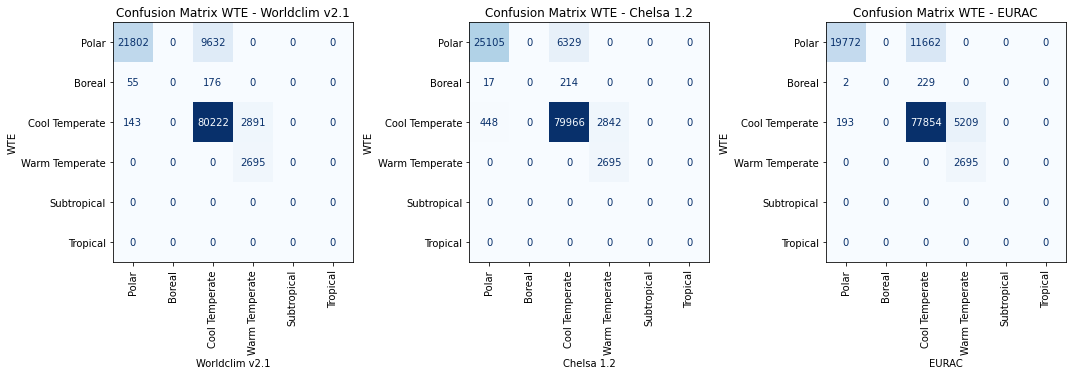

In [72]:
temperature_labels = ['Polar','Boreal','Cool Temperate','Warm Temperate','Subtropical','Tropical']

fig, ax = plt.subplots(1,3,figsize=(15,20))
cm_worldclim = confusion_matrix(wte_temp_UTM_masked_worldclim[0].fillna(-999).values.flatten(), worldclim_to_wte_UTM_masked.fillna(-999).values.flatten(), labels=[-999,0,1,2,3,4,5])
cm_worldclim = cm_worldclim[1:,1:]
plot_confusion_matrix(ax[0],cm_worldclim,[0,1,2,3,4,5],true="WTE",predicted="Worldclim v2.1", normalize=None)
ax[0].set_title("Confusion Matrix WTE - Worldclim v2.1")
ax[0].set_xticklabels(temperature_labels)
ax[0].set_yticklabels(temperature_labels)

cm_chelsa = confusion_matrix(wte_temp_UTM_masked_chelsa[0].fillna(-999).values.flatten(), chelsa_to_wte_UTM_masked.fillna(-999).values.flatten(), labels=[-999,0,1,2,3,4,5])
cm_chelsa = cm_chelsa[1:,1:]
plot_confusion_matrix(ax[1],cm_chelsa,[0,1,2,3,4,5],true="WTE",predicted="Chelsa 1.2", normalize=None)
ax[1].set_title("Confusion Matrix WTE - Chelsa 1.2")
ax[1].set_xticklabels(temperature_labels)
ax[1].set_yticklabels(temperature_labels)

cm_eurac = confusion_matrix(wte_temp_UTM_masked_eurac.fillna(-999).values.flatten(), eurac_to_wte_UTM_masked.fillna(-999).values.flatten(), labels=[-999,0,1,2,3,4,5])
cm_eurac = cm_eurac[1:,1:]
plot_confusion_matrix(ax[2],cm_eurac,[0,1,2,3,4,5],true="WTE",predicted="EURAC", normalize=None)
ax[2].set_title("Confusion Matrix WTE - EURAC")
ax[2].set_xticklabels(temperature_labels)
ax[2].set_yticklabels(temperature_labels)


plt.tight_layout()
plt.plot()